<a href="https://colab.research.google.com/github/royam0820/fastai2-v4/blob/master/12_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 8.3 MB/s 
     |████████████████████████████████| 1.2 MB 34.6 MB/s 
     |████████████████████████████████| 189 kB 35.0 MB/s 
     |████████████████████████████████| 46 kB 2.0 MB/s 
     |████████████████████████████████| 56 kB 2.2 MB/s 
     |████████████████████████████████| 51 kB 198 kB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *

In [ ]:
 !python --version

Python 3.7.12


# ResNets

In this chapter, we will build on top of the CNNs introduced in the previous chapter and explain to you the ResNet (residual network) architecture. It was introduced in 2015 by Kaiming He et al. in the article ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385) and is by far the most used model architecture nowadays. More recent developments in image models almost always use the same trick of residual connections, and most of the time, they are just a tweak of the original ResNet.

We will first show you the basic ResNet as it was first designed, then explain to you what modern tweaks make it more performant. But first, we will need a problem a little bit more difficult than the MNIST dataset, since we are already close to 100% accuracy with a regular CNN on it.

# Playing with Convolutions

In [ ]:
# amr - ConvLayer: channels in: 3, channels out: 64,  ks 3, padding 1, stride 1
c = nn.Conv2d(3, 64, kernel_size = 3, padding = 1); c

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
# amr - Simulate a 128 x 128 input

i = torch.randn(1, 3, 128, 128) # bs, channel, height, width
op = c(i)
print(f"Convolution Output shape: {op.shape}")

output = Flatten()(op)
print(f"Output after plain flattening: {output.shape}")

resnet_output = Flatten()(torch.mean(op, dim = (2, 3))) # taking the average of the 2nd and 3rd dimension (height, width)
print(f"Output after pooling and flattening: {resnet_output.shape}")

Convolution Output shape: torch.Size([1, 64, 128, 128])
Output after plain flattening: torch.Size([1, 1048576])
Output after pooling and flattening: torch.Size([1, 64])


NOTE: Once we are done with our convolutional layers (`op=c(i)`, we will get activations of size `bs x ch x h x w` (batch size, a certain number of channels, height, and width). Then we want to convert this to a tensor of size `bs x ch`, so we take the average over the last two dimensions and flatten the trailing 1×1 dimension like we did in our previous MNIST model (lesson 8) with a stride of 2. 

In [ ]:
# amr - Simulate a 224 x 224 input

i = torch.randn(1, 3, 224, 224) # bs, channel, height, width
op = c(i)
print(f"Convolution Output shape: {op.shape}")

output = Flatten()(op)
print(f"Output after plain flattening: {output.shape}")

resnet_output = Flatten()(torch.mean(op, dim = (2, 3))) # taking the average of the 2nd and 3rd dimension (height, width)
print(f"Output after pooling and flattening: {resnet_output.shape}")

Convolution Output shape: torch.Size([1, 64, 224, 224])
Output after plain flattening: torch.Size([1, 3211264])
Output after pooling and flattening: torch.Size([1, 64])


NOTE:  As seen from the above outputs, the plain flattening results change when we pass them through a conv layer.  However, averaging across the spatial dimensions before flattening keeps the output shape intact.

This makes resnets more convenient and versatile than plain old vgg/alexnet that were and are good starting points but mandate the input to be in some sort of a fixed shape.

# Imagenette
When fast.ai first started there were three main datasets that people used for building and testing computer vision models:

ImageNet:: 1.3 million images of various sizes around 500 pixels across, in 1,000 categories, which took a few days to train
MNIST:: 50,000 28×28-pixel grayscale handwritten digits
CIFAR10:: 60,000 32×32-pixel color images in 10 classes
The problem was that the smaller datasets didn't actually generalize effectively to the large ImageNet dataset. The approaches that worked well on ImageNet generally had to be developed and trained on ImageNet. This led to many people believing that only researchers with access to giant computing resources could effectively contribute to developing image classification algorithms.

We thought that seemed very unlikely to be true. We had never actually seen a study that showed that ImageNet happen to be exactly the right size, and that other datasets could not be developed which would provide useful insights. So we thought we would try to create a new dataset that researchers could test their algorithms on quickly and cheaply, but which would also provide insights likely to work on the full ImageNet dataset.

About three hours later we had created Imagenette. **We selected 10 classes from the full ImageNet that looked very different from one another. As we had hoped, we were able to quickly and cheaply create a classifier capable of recognizing these classes. We then tried out a few algorithmic tweaks to see how they impacted Imagenette. We found some that worked pretty well, and tested them on ImageNet as well—and we were very pleased to find that our tweaks worked well on ImageNet too!**

> There is an important message here: the dataset you get given is not necessarily the dataset you want. It's particularly unlikely to be the dataset that you want to do your development and prototyping in. You should aim to have an iteration speed of no more than a couple of minutes—that is, when you come up with a new idea you want to try out, you should be able to train a model and see how it goes within a couple of minutes. If it's taking longer to do an experiment, think about how you could cut down your dataset, or simplify your model, to improve your experimentation speed. The more experiments you can do, the better!

Let's get started with this dataset:

## Going Back to Imagenette

It's going to be tough to judge any improvements we make to our models when we are already at an accuracy that is as high as we saw on MNIST in the previous chapter, so we will tackle a tougher image classification problem by going back to Imagenette. We'll stick with small images to keep things reasonably fast.

Let's grab the data—we'll use the already-resized 160 px version to make things faster still, and will random crop to 128 px:

In [ ]:
# utility function to get a dataset with a pre-size of 160 px, resizing it to 128 px
# and returning a datablock
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

NOTE: Normalization: The pixel values of images range from 0 to 255. Images generally contain 3 color channels (Red, Green, and Blue). Sometimes some channels will be bright, some might be dull. Some might vary so much and some might not vary at all. It helps to train a model if all those 3 channels have got pixel values with a mean of 0 and a standard deviation of 1. Normalization simply does that.  Also, since we are using a pre-trained model on ImageNet, then the normalization that was used to pre-train ImageNet has to be applied to the new data.

In [ ]:
# getting the dataset from url, with a presize of 160 px and a resize of 128 px
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


In [ ]:
# amr - checking the number of classes and the lengths of the training and validation dataset
print(f"Number of classes: {dls.c}")
print(f"Length training set: {len(dls.train_ds)}, Length validation set: {len(dls.valid_ds)}")

Number of classes: 10
Length training set: 9469, Length validation set: 3925


NOTE: So, we see that there are close to 1000 train and 400 validation images for each category meaning there's **no class imbalance** in our dataset. And also our data is pretty diverse that way in the sense there's substantial distance between the classes. With this information about our dataset, let's dive into creating a resnet architecture that could take in these images and classify them into one of these 4 categories.

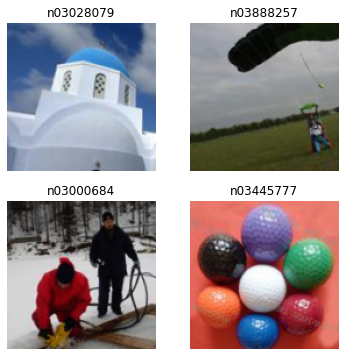

In [ ]:
dls.show_batch(max_n=4)

When we looked at MNIST we were dealing with 28×28-pixel images. **For Imagenette we are going to be training with 128×128-pixel images**. **Later, we would like to be able to use larger images as well—at least as big as 224×224 pixels, the ImageNet standard**. Do you recall how we managed to get a single vector of activations for each image out of the MNIST convolutional neural network?

**The approach we used (MNIST dataset) (lessson 8) was to ensure that there were enough stride-2 convolutions such that the final layer would have a grid size of 1**. Then we just flattened out the unit axes that we ended up with, to get a vector for each image (so, a matrix of activations for a mini-batch). We could do the same thing for Imagenette, but that would cause two problems:

- We'd need lots of stride-2 layers to make our grid 1×1 at the end—perhaps more than we would otherwise choose.
- The model would not work on images of any size other than the size we originally trained on.

One approach to dealing with the first of these issues would be to flatten the final convolutional layer in a way that handles a grid size other than 1×1. That is, we could simply flatten a matrix into a vector as we have done before, by laying out each row after the previous row. In fact, this is the approach that convolutional neural networks up until 2013 nearly always took. The most famous example is the 2013 ImageNet winner VGG, still sometimes used today. But there was another problem with this architecture: not only did it not work with images other than those of the same size used in the training set, but it required a lot of memory, because flattening out the convolutional layer resulted in many activations being fed into the final layers. Therefore, the weight matrices of the final layers were enormous.

This problem was solved through the creation of *fully convolutional networks*. **The trick in fully convolutional networks is to take the average of activations across a convolutional grid**. In other words, we can simply use this function:

In [ ]:
# function to convert a grid of activations into a single activation per image
def avg_pool(x): return x.mean((2,3))

As you see, it is taking the mean over the x- and y-axes. This function will always convert a grid of activations into a single activation per image. PyTorch provides a slightly more versatile module called `nn.AdaptiveAvgPool2d`, which averages a grid of activations into whatever sized destination you require (although we nearly always use a size of 1).

> **A fully convolutional network, therefore, has a number of convolutional layers, some of which will be stride 2, at the end of which is an adaptive average pooling layer, a flatten layer to remove the unit axes, and finally a linear layer**. Here is our first fully convolutional network:

In [ ]:
# defining a fully convolutional layer
# conv block definition
def block(ni, nf): return ConvLayer(ni, nf, stride=2)
# model definition
def get_model():
    return nn.Sequential(
        block(3, 16),         # 64
        block(16, 32),        # 32
        block(32, 64),        # 16
        block(64, 128),       # 8
        block(128, 256),      # 4
        nn.AdaptiveAvgPool2d(1), # output size
        Flatten(),
        nn.Linear(256, dls.c))

NOTE: The fastai `ConvLayer` does Conv2d, BatchNorm2d and ReLu.

NB: As the number of filters (channels) increased the output feature map decreases.

`nn.AdaptiveAvgPool2d(1)` downsamples the input along its spatial dimensions (height and width) by taking the average value over an input window. 


In [ ]:
# testing the block definition
block(3,16)

ConvLayer(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

In [ ]:
# amr computing the output feature map
# the formula (n + 2*pad - ks)//stride + 1
# example with an image size 128x128 pixels, ks=3, pad=1, stride=1
(128 + 2*1 - 3)//2 + 1

64

In [ ]:
# amr - creating a function to get the activation map dimension
pad = 1
ks = 3
stride = 2

def get_act_dim(height,width):
 '''get activation map dimensions'''
 def _calc(n): return (n + 2*pad - ks)//stride + 1  # the formula
 return _calc(height), _calc(width) # returns the activation map dimension

In [ ]:
# amr - using the function
layer1 = get_act_dim(128, 128); print(layer1)
layer2 = get_act_dim(*layer1); print(layer2)
layer3 = get_act_dim(*layer2); print(layer3)
layer4 = get_act_dim(*layer3); print(layer4)
layer5 = get_act_dim(*layer4); print(layer5)

(64, 64)
(32, 32)
(16, 16)
(8, 8)
(4, 4)


NOTE: for a 128x128 input, the output features maps will be: 64, 32, 16, 8, 4

In [ ]:
doc(ConvLayer)

In [ ]:
# ??ConvLayer

In [ ]:
# ??nn.AdaptiveAvgPool2d

We're going to be replacing the implementation of `block` in the network with other variants in a moment, which is why we're not calling it `conv` any more. We're also saving some time by taking advantage of fastai's `ConvLayer`, which that already provides the functionality of `conv` from the last chapter (plus a lot more!).

> stop: Consider this question: would this approach makes sense for an optical character recognition (OCR) problem such as MNIST? The vast majority of practitioners tackling OCR and similar problems tend to use fully convolutional networks, because that's what nearly everybody learns nowadays. But it really doesn't make any sense! You can't decide, for instance, whether a number is a 3 or an 8 by slicing it into small pieces, jumbling them up, and deciding whether on average each piece looks like a 3 or an 8. But that's what adaptive average pooling effectively does! **Fully convolutional networks are only really a good choice for objects that don't have a single correct orientation or size (e.g., like most natural photos)**.

Once we are done with our convolutional layers, we will get activations of size `bs x ch x h x w` (batch size, a certain number of channels, height, and width). **We want to convert this to a tensor of size `bs x ch`, so we take the average over the last two dimensions and flatten the trailing 1×1 dimension like we did in our previous model**. 

This is different from regular pooling in the sense that those layers will generally take the average (for average pooling) or the maximum (for max pooling) of a window of a given size. For instance, max pooling layers of size 2, which were very popular in older CNNs, reduce the size of our image by half on each dimension by taking the maximum of each 2×2 window (with a stride of 2).

As before, we can define a `Learner` with our custom model and then train it on the data we grabbed earlier:

In [ ]:
# defining a learner
def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy
                  ).to_fp16()

# calling the model defined above
learn = get_learner(get_model())

NOTE: the learner holds a dataloader, a model, a loss function, a metric, the optimizer by default is Adam.

See below the model we defined above.

**formula for the output feature map**
`n + 2*pad - ks)//stride + 1`

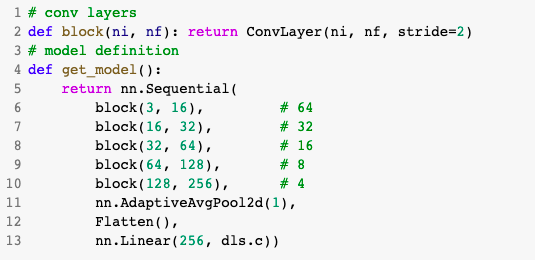

In [ ]:
# checking the architecture of the model
learn.model

Sequential(
  (0): ConvLayer(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (4): ConvLayer(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256

In [ ]:
learn.summary()

Sequential (Input shape: 128 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 16 x 64 x 64  
Conv2d                                    432        True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 32 x 32 x 32  
Conv2d                                    4608       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 16 x 16  
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
__________________________________

NOTE: `learn.summary` The first conv is `conv(3,16)`, by default the “kernel” size is 3x3, so to know the number of parameters, you just multiply all of these numbers as follows: `3*16*3*3=432`. 

SuggestedLRs(valley=0.00019054606673307717)

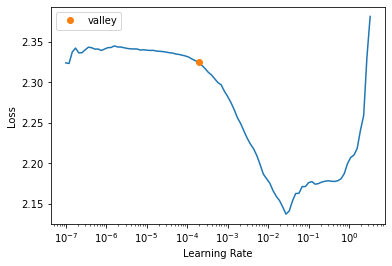

In [ ]:
# finding the best learning rate (lr)
learn.lr_find()

3e-3 is often a good learning rate for CNNs, and that appears to be the case here too, so let's try that:

In [ ]:
3e-3

0.003

In [ ]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.857359,1.869612,0.376051,00:34
1,1.505176,1.481759,0.516178,00:34
2,1.272682,1.363827,0.558471,00:34
3,1.117564,1.044958,0.668025,00:34
4,1.033695,1.033705,0.672357,00:34


**That's a pretty good start, considering we have to pick the correct one of 10 categories, and we're training from scratch for just 5 epochs!** We can do way better than this using a deeper mode, but just stacking new layers won't really improve our results (you can try and see for yourself!). To work around this problem, ResNets introduce the idea of *skip connections*. We'll explore those and other aspects of ResNets in the next section.

## Building a Modern CNN: ResNet

We now have all the pieces we need to build the models we have been using in our computer vision tasks since the beginning of this book: ResNets. We'll introduce the main idea behind them and show how it improves accuracy on Imagenette compared to our previous model, before building a version with all the recent tweaks.

### Skip Connections

In 2015, the authors of the ResNet paper noticed something that they found curious. Even after using batchnorm, they saw that **a network using more layers was doing less well than a network using fewer layers—and there were no other differences between the models**. Most interestingly, the difference was observed not only in the validation set, but also in the training set; so, it wasn't just a generalization issue, but a training issue. As the paper explains:

> : Unexpectedly, such degradation is not caused by overfitting, and adding more layers to a suitably deep model leads to higher training error, as [previously reported] and thoroughly verified by our experiments.

This phenomenon was illustrated by the graph below showing training of networks of different depth, with training error on the left and test error on the right.

**Training of networks of different length.**

<img alt="Training of networks of different depth" width="700" caption="Training of networks of different depth (courtesy of Kaiming He et al.)" id="resnet_depth" src="https://github.com/fastai/fastbook/blob/master/images/att_00042.png?raw=1">

NOTE: **Issue: The 56-layer model has a worse training and testing error compared to the 20-layer model**

As the authors mention here, they are not the first people to have noticed this curious fact. But they were the first to make a very important leap:

> : Let us consider a shallower architecture and its deeper counterpart that adds more layers onto it. There exists a solution by construction to the deeper model: the added layers are identity mapping, and the other layers are copied from the learned shallower model.

As this is an academic paper this process is described in a rather inaccessible way, but the concept is actually very simple: start with a 20-layer neural network that is trained well, and add another 36 layers that do nothing at all (for instance, they could be linear layers with a single weight equal to 1, and bias equal to 0). The result will be a 56-layer network that does exactly the same thing as the 20-layer network, proving that there are always deep networks that should be *at least as good* as any shallow network. But for some reason, SGD does not seem able to find them.

> jargon: **Identity mapping: Returning the input without changing it at all. This process is performed by an _identity function_.**

Actually, there is another way to create those extra 36 layers, which is much more interesting. What if we replaced every occurrence of `conv(x)` with `x + conv(x)`, where `conv` is the function from the previous chapter that adds a second convolution, then a batchnorm layer, then a ReLU. Furthermore, recall that batchnorm does `gamma*y + beta`. What if we initialized `gamma` to zero for every one of those final batchnorm layers? Then our `conv(x)` for those extra 36 layers will always be equal to zero, which means `x+conv(x)` will always be equal to `x`.

What has that gained us? **The key thing is that those 36 extra layers, as they stand, are an *identity mapping*, but they have *parameters*, which means they are *trainable***. So, we can start with our best 20-layer model, add these 36 extra layers which initially do nothing at all, and then *fine-tune the whole 56-layer model*. Those extra 36 layers can then learn the parameters that make them most useful.

The ResNet paper actually proposed a variant of this, which is to instead "skip over" every second convolution, so effectively we get `x+conv2(conv1(x))`. This is shown by the diagram below (A simple Resnet block) (from the paper).

**A ResNet Block.**

<img alt="A simple ResNet block" width="331" caption="A simple ResNet block (courtesy of Kaiming He et al.)" id="resnet_block" src="https://github.com/fastai/fastbook/blob/master/images/att_00043.png?raw=1">

NOTE: So, to solve the problem of vanishing/exploding gradients, every 2 conv, a skip connection is added to add the input x to the output after 2 few weight layers as  shown above. In summary, instead of doing `output = conv2(conv1(x))` let's do `output = x+conv2(conv1(x))`; `x` is called in the paper the *identity connection* also called the *skip connection*.

That arrow on the right is just the `x` part of `x+conv2(conv1(x))`, and is known as the *identity branch* or *skip connection*. The path on the left is the `conv2(conv1(x))` part. You can think of the identity path as providing a direct route from the input to the output.

In a ResNet, we don't actually proceed by first training a smaller number of layers, and then adding new layers on the end and fine-tuning. Instead, we use ResNet blocks like the one in the diagram above throughout the CNN, initialized from scratch in the usual way, and trained with SGD in the usual way. **We rely on the skip connections to make the network easier to train with SGD**.

There's another (largely equivalent) way to think of these ResNet blocks. This is how the paper describes it:

> : Instead of hoping each few stacked layers directly fit a desired underlying mapping, we explicitly let these layers fit a residual mapping. Formally, denoting the desired underlying mapping as H(x), we let the stacked nonlinear layers fit another mapping of F(x) := H(x)−x. The original mapping is recast into F(x)+x. We hypothesize that it is easier to optimize the residual mapping than to optimize the original, unreferenced mapping. To the extreme, if an identity mapping were optimal, it would be easier to push the residual to zero than to fit an identity mapping by a stack of nonlinear layers.

Again, this is rather inaccessible prose—so let's try to restate it in plain English! 
> If the outcome of a given layer is `x`, **when using a ResNet block that returns `y = x+block(x)` we're not asking the block to predict `y`, we are asking it to predict the difference between `y` and `x`**. **So the job of those blocks isn't to predict certain features, but to minimize the error between `x` and the desired `y`**. A ResNet is, therefore, good at learning about slight differences between doing nothing and passing though a block of two convolutional layers (with trainable weights). This is how these models got their name: they're predicting **residuals** (**reminder: "residual" is prediction minus target**).

One key concept that both of these two ways of thinking about ResNets share is the idea of ease of learning. This is an important theme. Recall the universal approximation theorem, which states that a sufficiently large network can learn anything. This is still true, but there turns out to be a very important difference between what a network *can learn* in principle, and what it is *easy for it to learn* with realistic data and training regimes. Many of the advances in neural networks over the last decade have been like the ResNet block: the result of realizing how to make something that was always possible actually feasible.

> note: True Identity Path: The original paper didn't actually do the trick of using zero for the initial value of `gamma` in the last batchnorm layer of each block; that came a couple of years later. So, the original version of ResNet didn't quite begin training with a truly identity path through the ResNet blocks, but nonetheless having the ability to "navigate through" the skip connections did indeed make it train better. Adding the batchnorm `gamma` init trick made the models train at even higher learning rates.

**Here's the definition of a simple ResNet block (where `norm_type=NormType.BatchZero` causes fastai to init the `gamma` weights of the last batchnorm layer to zero)**:

In [ ]:
# a simple ResNet block
class ResBlock(Module):
    def __init__(self, ni, nf):
        self.convs = nn.Sequential(
            ConvLayer(ni,nf), #stride=1),
            ConvLayer(nf,nf, norm_type=NormType.BatchZero)) # init gamma weights to zero
        
    def forward(self, x): return x + self.convs(x)

NB1: fastai initialises the `gamma` weights for the last batchnorm layer to zero because of norm_type=NormType.BatchZero).

NB2: BatchNorm does `gamma*y + beta`) `gamma` and `beta` are learned parameters (just like neural network weights).

NOTE:  **Issue with the ResNet block, cannot apply a stride > 1 and it requires that ni==nf. Indeed, if a stride = 2, the grid size of the output activation will be half the size and therefore we can add back to x in forward because x and the output have different shapes**.

The issue is that with a stride of, say, 2 on one of the convolutions, the grid size of the output activations will be half the size on each axis of the input. So then we can't add that back to `x` in `forward` because `x` and the output activations have different dimensions. The same basic issue occurs if `ni!=nf`: the shapes of the input and output connections won't allow us to add them together.

To fix this, we need a way to change the shape of `x` to match the result of `self.convs`. Halving the grid size can be done using an average pooling layer with a stride of 2: that is, a layer that takes 2×2 patches from the input and replaces them with their average.

Changing the number of channels can be done by using a convolution. We want this skip connection to be as close to an identity map as possible, however, which means making this convolution as simple as possible. The simplest possible convolution is one where the kernel size is 1. That means that the kernel is size `ni*nf*1*1`, so it's only doing a dot product over the channels of each input pixel—it's not combining across pixels at all. This kind of *1x1 convolution* is very widely used in modern CNNs, so take a moment to think about how it works.

> jargon: **1x1 convolution: A convolution with a kernel size of 1.**

Here's a ResBlock using these tricks to handle changing shape in the skip connection:

In [ ]:
# Defining a convolution with stride
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero))

In [ ]:
_conv_block(3,16,2) #ni, nf, stride

Sequential(
  (0): ConvLayer(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

NOTE: the first conv has stride 2, and the next conv has a stride of 1 and no ReLu.

In [ ]:
# Taking into account possible input size v.s. output feature size 
class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None) # identity connection
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

NOTE: 
- `self.idconv`: if `ni==nf` no operation is done otherwise a convolution with a kernel size of 1 is done
- `self.pool`: if `stride==1` no operation otherwise proceed to Average pooling with a stride of 2, a layer that takes a 2x2 patches from the input and replaces them with their average. 
- `act_cls=None` the ReLu activation is removed from the final convolution in `convs` and in `idconv`.  It is moved after we add the skip connection.  The thinking behing it is that the whole ResNet block is like a layer and you want your activation to be after your layer.
- `nn.AvgPool2d(2, ceil_mode=True)` this instruction is giving a kernel size of 2 and a computation mode of `ceil` instead of `floor`.

Note that we're using the `noop` function here, which simply returns its input unchanged (*noop* is a computer science term that stands for "no operation"). In this case, `idconv` does nothing at all if `ni==nf`, and `pool` does nothing if `stride==1`, which is what we wanted in our skip connection.

Also, you'll see that we've removed the ReLU (`act_cls=None`) from the final convolution in `convs` and from `idconv`, and moved it to *after* we add the skip connection. The thinking behind this is that the whole ResNet block is like a layer, and you want your activation to be after your layer.

Let's replace our `block` with `ResBlock`, and try it out:

In [ ]:
# Replacing our block with a ResBlock
def block(ni,nf): return ResBlock(ni, nf, stride=2)
learn = get_learner(get_model())

In [ ]:
learn.summary()

Sequential (Input shape: 128 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 16 x 64 x 64  
Conv2d                                    432        True      
BatchNorm2d                               32         True      
ReLU                                                           
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
Conv2d                                    48         True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     128 x 3 x 64 x 64   
AvgPool2d                                                      
____________________________________________________________________________
                     128 x 32 x 32 x 32  
Conv2d                                    4608       True      
BatchNorm2d                       

In [ ]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.971797,1.830081,0.368662,00:35
1,1.673064,1.483387,0.511338,00:35
2,1.386501,1.293486,0.582166,00:36
3,1.175133,1.126561,0.643567,00:35
4,1.041796,1.045525,0.665478,00:35


NOTE: It's not much better. But the whole point of this was to allow us to train *deeper* models, and we're not really taking advantage of that yet. To create a model that's, say, twice as deep, all we need to do is replace our `block` with two `ResBlock`s in a row:

In [ ]:
# # adding two resblock in a row, one with stride 2 and one with stride 1
def block(ni, nf):
    return nn.Sequential(ResBlock(ni, nf, stride=2), ResBlock(nf, nf))

In [ ]:
block(3,16)

Sequential(
  (0): ResBlock(
    (convs): Sequential(
      (0): ConvLayer(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ConvLayer(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idconv): ConvLayer(
      (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (1): ResBlock(
    (convs): Sequential(
      (0): ConvLayer(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_s

NOTE: Output with two ResBlocks

In [ ]:
learn = get_learner(get_model())

In [ ]:
learn.summary()

Sequential (Input shape: 128 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 16 x 64 x 64  
Conv2d                                    432        True      
BatchNorm2d                               32         True      
ReLU                                                           
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
Conv2d                                    48         True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     128 x 3 x 64 x 64   
AvgPool2d                                                      
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
ReLU                                                           
Conv2d                   

In [ ]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.924533,1.811661,0.377325,00:37
1,1.595364,1.608606,0.468535,00:37
2,1.289710,1.182910,0.630064,00:37
3,1.079101,0.969072,0.698599,00:37
4,0.938894,0.920389,0.705987,00:37


NOTE:  Now we're making good progress!

The authors of the ResNet paper went on to win the 2015 ImageNet challenge. At the time, this was by far the most important annual event in computer vision. We have already seen another ImageNet winner: the 2013 winners, Zeiler and Fergus. It is interesting to note that in both cases the starting points for the breakthroughs were experimental observations: observations about what layers actually learn, in the case of Zeiler and Fergus, and observations about which kinds of networks can be trained, in the case of the ResNet authors. This ability to design and analyze thoughtful experiments, or even just to see an unexpected result, say "Hmmm, that's interesting," and then, most importantly, set about figuring out what on earth is going on, with great tenacity, is at the heart of many scientific discoveries. **Deep learning is not like pure mathematics. It is a heavily experimental field, so it's important to be a strong practitioner, not just a theoretician**.

Since the ResNet was introduced, it's been widely studied and applied to many domains. One of the most interesting papers, published in 2018, is Hao Li et al.'s ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/abs/1712.09913). **It shows that using skip connections helps smooth the loss function, which makes training easier as it avoids falling into a very sharp area.** **The image below shows a stunning picture from the paper, illustrating the difference between the bumpy terrain that SGD has to navigate to optimize a regular CNN (left) versus the smooth surface of a ResNet (right).**

**Visualizing the Resnet Loss Landscape.**

<img alt="Impact of ResNet on loss landscape" width="600" caption="Impact of ResNet on loss landscape (courtesy of Hao Li et al.)" id="resnet_surface" src="https://github.com/fastai/fastbook/blob/master/images/att_00044.png?raw=1">

Our first model is already good, but further research has discovered more tricks we can apply to make it better. We'll look at those next.

### A State-of-the-Art ResNet

In ["Bag of Tricks for Image Classification with Convolutional Neural Networks"](https://arxiv.org/abs/1812.01187), Tong He et al. **study different variations of the ResNet architecture** that come at almost no additional cost in terms of number of parameters or computation. By using a tweaked ResNet-50 architecture and Mixup they achieved 94.6% top-5 accuracy on ImageNet, in comparison to 92.2% with a regular ResNet-50 without Mixup. This result is better than that achieved by regular ResNet models that are twice as deep (and twice as slow, and much more likely to overfit).

> jargon: **top-5 accuracy**: A metric testing how often the label we want is in the top 5 predictions of our model. It was used in the ImageNet competition because many of the images contained multiple objects, or contained objects that could be easily confused or may even have been mislabeled with a similar label. In these situations, looking at top-1 accuracy may be inappropriate. **However, recently CNNs have been getting so good that top-5 accuracy is nearly 100%, so some researchers are using top-1 accuracy for ImageNet too now**.

We'll use this tweaked version as we scale up to the full ResNet, because it's substantially better. It differs a little bit from our previous implementation, in that instead of just starting with ResNet blocks, it begins with a few convolutional layers followed by a max pooling layer. This is what the first layers, called the *stem* of the network, look like:

Defining a tweaked version as we scale up to a full ResNet.

In [ ]:
# stem: The first layers of a CNN.
# doing the first layers with a few convolutions followed by a max pool layer
def _resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1)
            for i in range(len(sizes)-1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

In [ ]:
# 3 conv layers (3, 32; 32, 32;  32, 64)
_resnet_stem(3,32,32,64)

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

NOTE: a ResNet block has three convolutions and a pooling layer.

```
[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1)
   (2): ReLU()
 ), MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False)]
 ```

> jargon: **Stem**: The first few layers of a CNN. Generally, the stem has a different structure than the main body of the CNN.

**The reason that we have a stem of plain convolutional layers, instead of ResNet blocks, is based on a very important insight about all deep convolutional neural networks: the vast majority of the computation occurs in the early layers. Therefore, we should keep the early layers as fast and simple as possible.**

To see why so much computation occurs in the early layers, consider the very first convolution on a 128-pixel input image. If it is a stride-1 convolution, then it will apply the kernel to every one of the 128×128 pixels. That's a lot of work! In the later layers, however, the grid size could be as small as 4×4 or even 2×2, so there are far fewer kernel applications to do.

On the other hand, the first-layer convolution only has 3 input features and 32 output features. Since it is a 3×3 kernel, this is 3×32×3×3 = 864 parameters in the weights. But the last convolution will have 256 input features and 512 output features, resulting in 1,179,648 weights! So the first layers contain the vast majority of the computation, but the last layers contain the vast majority of the parameters.

A ResNet block takes more computation than a plain convolutional block, since (in the stride-2 case) a ResNet block has three convolutions and a pooling layer. That's why we want to have plain convolutions to start off our ResNet.



We're now ready to show the implementation of a **modern ResNet**, with the "bag of tricks." It uses four groups of ResNet blocks, with 64, 128, 256, then 512 filters. Each group starts with a stride-2 block, except for the first one, since it's just after a `MaxPooling` layer:

In [ ]:
# ResNet - bag of tricks implementation
class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(3,32,32,64)
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): self.block_szs[i] *= expansion
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool2d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))
    
    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)
        ])

NOTE: The first layer is going from `ch_in` to `ch_out`, with the indicated `stride` and all the others are blocks of stride 1 with `ch_out` to `ch_out` tensors. Once the blocks are defined, our model is purely sequential which is why we define it as a subclass of `nn.sequential`, (ignore the expansion parameter for now), to be discussed next chapter, for the moment it is 1 so it does not do anything.

The `_make_layer` function is just there to create a series of `n_layers` blocks. The first one is going from `ch_in` to `ch_out` with the indicated `stride` and all the others are blocks of stride 1 with `ch_out` to `ch_out` tensors. Once the blocks are defined, our model is purely sequential, which is why we define it as a subclass of `nn.Sequential`. (Ignore the `expansion` parameter for now; we'll discuss it in the next section. For now, it'll be `1`, so it doesn't do anything.)

The various versions of the models (ResNet-18, -34, -50, etc.) just change the number of blocks in each of those groups. This is the definition of a ResNet-18:

In [ ]:
# Resnet18
rn = ResNet(dls.c, [2,2,2,2]); rn

ResNet(
  (0): ConvLayer(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): ConvLayer(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

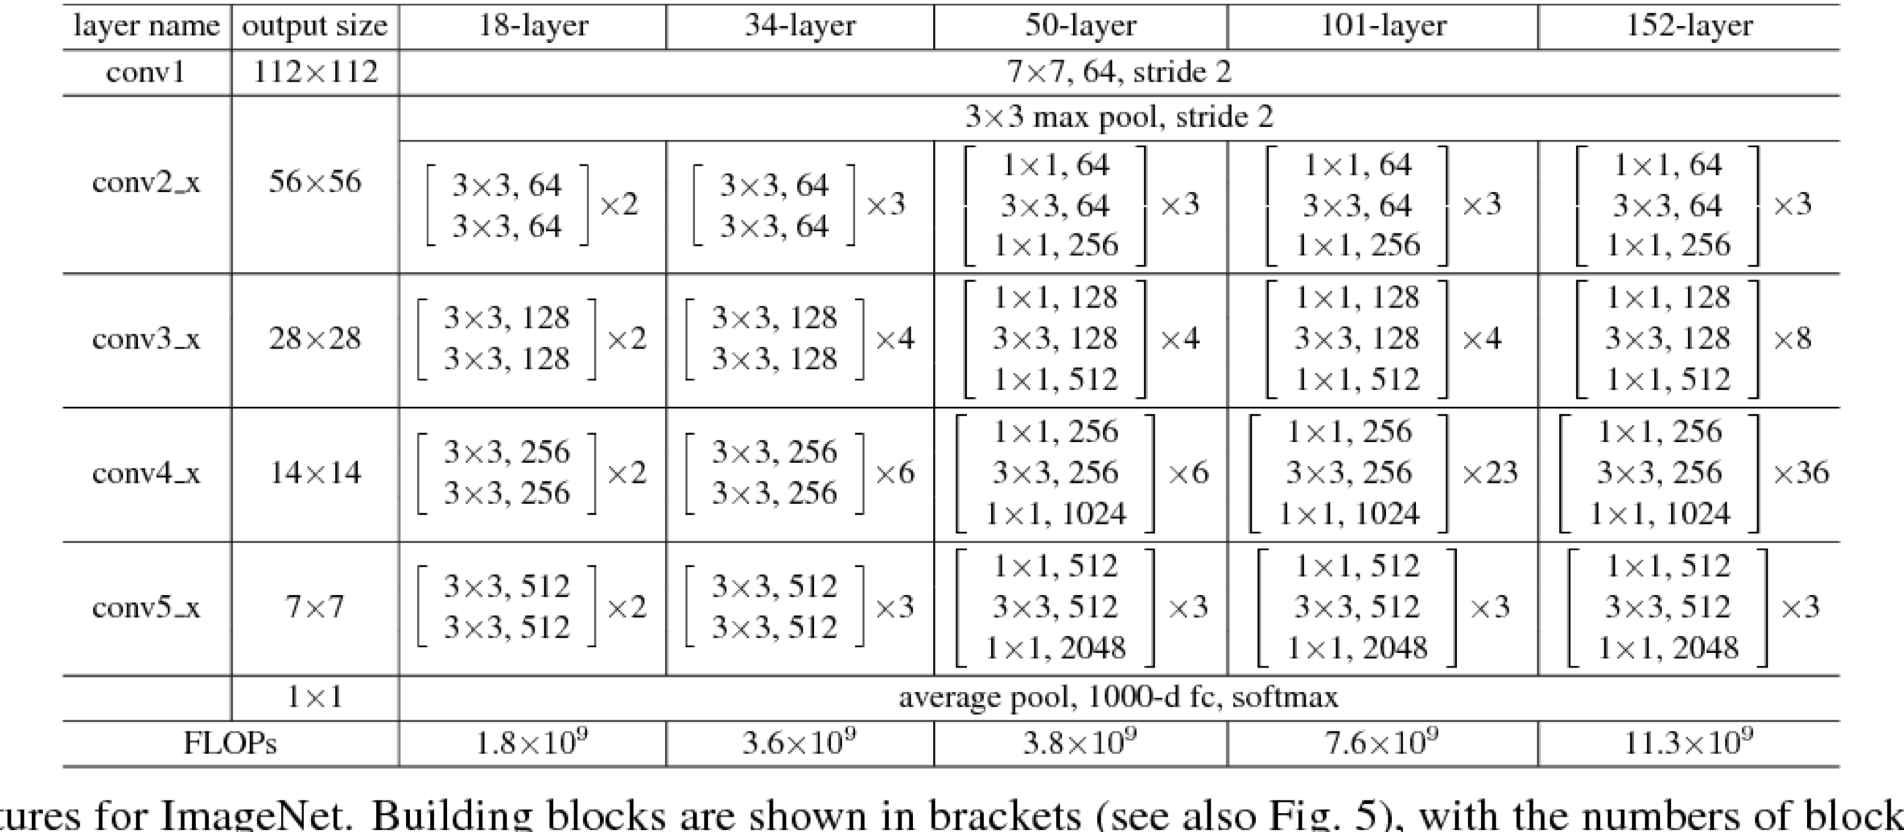

NOTE: 
- Resnet18 - Input [2, 2, 2, 2]
- Formula = 2 + 2x2 + 2x2 + 2x2 + 2x2 = 18

- Resnet50 - Input [3, 4, 6, 3]
- Formula = 2 + 3x3 + 4x3 + 6x3 + 3x3 = 50


Let's train it for a little bit and see how it fares compared to the previous model:

In [ ]:
learn = get_learner(rn)

In [ ]:
learn.model

ResNet(
  (0): ConvLayer(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): ConvLayer(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:
learn.summary()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


ResNet (Input shape: 128 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 32 x 64 x 64  
Conv2d                                    864        True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 64 x 64  
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 32 x 32  
MaxPool2d                             

In [ ]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.705444,2.199027,0.326115,00:38
1,1.326318,1.152727,0.630573,00:38
2,1.078135,1.218658,0.609936,00:38
3,0.892986,0.865081,0.722548,00:38
4,0.760140,0.777606,0.754395,00:38


NOTE: Even though we have more channels (and our model is therefore even more accurate), our training is just as fast as before, thanks to our optimized stem.

To make our model deeper without taking too much compute or memory, we can use another kind of layer introduced by the ResNet paper for ResNets with a depth of 50 or more: the bottleneck layer. 

### Bottleneck Layers

Instead of stacking two convolutions with a kernel size of 3, bottlenecks layers use 3 convolutions:

- two 1x1 (at the beginning and the end) and
- one 3x3 as showns on the right figure below.

as shown on the right of the figure below.


**Regular ResNet Block v.s.Bottleneck ResNet Block**

<img alt="Comparison of regular and bottleneck ResNet blocks" width="550" caption="Comparison of regular and bottleneck ResNet blocks (courtesy of Kaiming He et al.)" id="resnet_compare" src="https://github.com/fastai/fastbook/blob/master/images/att_00045.png?raw=1">

Why is that useful? 1×1 convolutions are much faster, so even if this seems to be a more complex design, this block executes faster than the first ResNet block we saw. **This then lets us use more filters: as we see in the illustration, the number of filters in and out is 4 times higher (256 instead of 64) diminish then restore the number of channels (hence the name bottleneck)**. The overall impact is that we can use more filters in the same amount of time.

Let's try replacing our `ResBlock` with this bottleneck design:

In [ ]:
# Replacing the ResNetBlock with a Bottleneck ResNet design
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf//4, 1),
        ConvLayer(nf//4, nf//4, stride=stride), 
        ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero))

NOTE: the number of filters are diminished for the the two ConvLayer (`nf//4`) and then restore at the last Convlayer(`nf`)

In [ ]:
_conv_block(3, 16, 2)

Sequential(
  (0): ConvLayer(
    (0): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

**We'll use this to create a ResNet-50 with group sizes of `(3,4,6,3)`. We now need to pass `4` in to the `expansion` parameter of `ResNet`, since we need to start with four times less channels and we'll end with four times more channels**.

Deeper networks like this don't generally show improvements when training for only 5 epochs, so we'll bump it up to 20 epochs this time to make the most of our bigger model. And to really get great results, let's use bigger images too:

In [ ]:
# using a bigger image size 224 px
dls = get_data(URLs.IMAGENETTE_320, presize=320, resize=224)

We don't have to do anything to account for the larger 224-pixel images; thanks to our fully convolutional network, it just works. This is also why we were able to do *progressive resizing* earlier in the book—the models we used were fully convolutional, so we were even able to fine-tune models trained with different sizes. We can now train our model and see the effects:

In [ ]:
# ResNet50
rn = ResNet(dls.c, [3,4,6,3], 4)

In [ ]:
learn = get_learner(rn)

In [ ]:
learn.model

ResNet(
  (0): ConvLayer(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): ConvLayer(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

In [ ]:
learn.summary()

ResNet (Input shape: 128 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 32 x 112 x 11 
Conv2d                                    864        True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 112 x 11 
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 56 x 56  
MaxPool2d                             

In [ ]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.623092,1.488922,0.505732,01:24
1,1.386533,2.272137,0.418599,01:24
2,1.257712,1.581686,0.561274,01:24
3,1.150051,1.584651,0.524841,01:24
4,1.067420,2.006275,0.447389,01:24
5,0.955769,1.793744,0.531210,01:24
6,0.870199,2.283627,0.419873,01:24
7,0.798167,2.530010,0.494013,01:24
8,0.728824,1.021117,0.685350,01:24
9,0.676778,2.144156,0.529172,01:24


NOTE: We're getting a great result now! Try adding Mixup, and then training this for a hundred epochs while you go get lunch. You'll have yourself a very accurate image classifier, trained from scratch.

The bottleneck design we've shown here is typically only used in ResNet-50, -101, and -152 models. ResNet-18 and -34 models usually use the non-bottleneck design seen in the previous section. However, we've noticed that the bottleneck layer generally works better even for the shallower networks. This just goes to show that the little details in papers tend to stick around for years, even if they're actually not quite the best design! Questioning assumptions and "stuff everyone knows" is always a good idea, because this is still a new field, and there are lots of details that aren't always done well.

In [ ]:
resnet50()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Conclusion

You have now seen how the models we have been using for computer vision since the first chapter are built, using skip connections to allow deeper models to be trained. Even if there has been a lot of research into better architectures, they all use one version or another of this trick, to make a direct path from the input to the end of the network. When using transfer learning, the ResNet is the pretrained model. In the next chapter, we will look at the final details of how the models we actually used were built from it.

ResNet 
- solves the degradation problem
- results in faster training of deep networks
- negligible extra parameters
- tackles vanishing gradient problem
- gives higher accuracy




## Questionnaire

1. How did we get to a single vector of activations in the CNNs used for MNIST in previous chapters? Why isn't that suitable for Imagenette?
> We used enough stride 2 convs to ensure that the final layer has a activation map dimension of 1x1. Then we used nn.Flatten() to remove the 1x1 unit axes. This gives us a matrix of activations by batch. This method in MNIST assumed a starting image size` of 28x28.
This method is not suitable for Imagette because our images might be larger than 28x28.
1. What do we do for Imagenette instead?
> We use fully convolution neural networks. In these networks we take the average of activations across the convolutional grid. This will convert a grid of activations into a single activation per image.
1. What is "adaptive pooling"?
> In average pooling you set the ks and the stride yourself. In adaptive average pooling you specify the output. The ks and stride are auto detected. It's less work for you. https://stackoverflow.com/questions/58692476/what-is-adaptive-average-pooling-and-how-does-it-work
1. What is "average pooling"?
> It computes the average presence of a feature.
1. Why do we need `Flatten` after an adaptive average pooling layer?
> The activation map has a unit dimension (1x1) after the adaptive average pooling layer. nn.Flatten() removes the unit axes.
1. What is a "skip connection"?
> In a skip connection we do `x+conv2(conv1(x))`. The batchnorm has a `gamma`  set to 0. As a result `x+conv2(conv1(x))` will be equal to x initially. So the network does nothing and returns the identity matrix.  The parameters are then trained to make the skip connection more useful. 
1. Why do skip connections allow us to train deeper models?
> A resnet is good at measuring Opportunity Cost.
It measures the cost of doing nothing (returning the identity) vs the cost of doing something (passing the block through two conv layers with trainable weights). Sometimes doing nothing is a valid choice. In this case the network places less emphasis on the resblock - saving time and valuable compute.  This allows us to train deeper models.
1. What does resnet graph show? How did that lead to the idea of skip connections?
> The resnet depth graphs shows that more layers does not necessarily yield better results. The 56 layer model has a worse training and testing error compared to the 20 layer model.  This led to the idea of starting with a 20 layer network and addding 36 additional layers that do nothing. The 56 layer network should be at least as good as the 20 layer network.  But the additional 36 layers have trainable parameters. So there's an (almost) asymmetric risk/reward.  The worst that can happen is that the loss is the same as the 20 layer network. The best thing that can happen is that the loss is significantly better than the 20 layer network.
1. What is "identity mapping"?
> A mapping that returns the original input matrix.
1. What is the basic equation for a ResNet block (ignoring batchnorm and ReLU layers)?
> `x+conv2(conv1(x))` where x is the input tensor. This would be called in the forward function.
1. What do ResNets have to do with residuals?
> Resnets are good at detecting the difference between doing nothing and passing a batch through 2 convolutional layers (with trainable weights). This difference can be thought of as the residual (prediction - target).

1. How do we deal with the skip connection when there is a stride-2 convolution? How about when the number of filters changes?
> Stride 2 conv: We use average pooling with a stride of 2.  Number of filters changes: We use a conv layer with a kernel size of 1 and our desired number of output filters.
1. How can we express a 1×1 convolution in terms of a vector dot product?
> It is doing a dot product over the channels of each input pixel.  At each cell in the 6x6 matrix below we do the following dot product:

> $\begin{pmatrix} r &amp; g &amp; b \end{pmatrix} . \begin{pmatrix} y1 \\ y2 \\ y3 \end{pmatrix}$

> where r, g, b are the cells from the red, green, blue matrices respectively
> 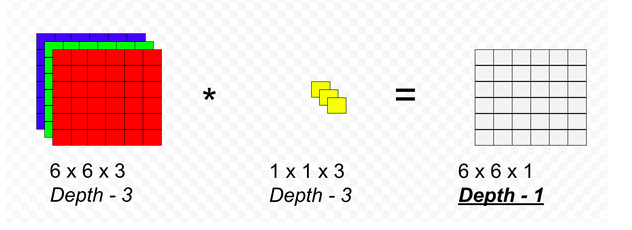

1. Create a `1x1 convolution` with `F.conv2d` or `nn.Conv2d` and apply it to an image. What happens to the `shape` of the image?
> 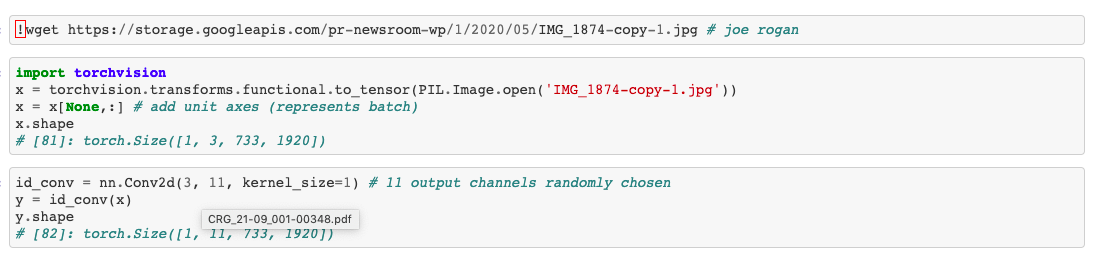
> The shape changes to whatever is designated by the number of channels out. In this case I've picked 11 randomly.
1. What does the `noop` function return?
> The input. It is a function that does nothing.
1. Explain what is shown in regarding the graph on the loss landscape with ResNet.
> This image shows a regular CNN's loss landscape compared to a ResNet's loss lanscape. The regular CNN has a signficant number of peaks and valleys. It would be difficult for SGD to navigate this terrain to find the global minimum.  On the other hand the ResNet's loss landscape is smooth and has an easy path to find the global minimum.
1. When is top-5 accuracy a better metric than top-1 accuracy?
> Top-5 accuracy tests how often the label is in the top 5 predictions of the model. It's useful when training with mulitple different objects or objects that are easily confused with one another.
1. What is the "stem" of a CNN?
> The first few layers of the network. The stem will have a different structure than the main body of the CNN.
1. Why do we use plain convolutions in the CNN stem, instead of ResNet blocks?
> The vast majority of computations occur in the early layers. This is because the image size is typically still quite large in the early layers.  To speed things up we use plain convolutions in the CNN stem.
1. How does a bottleneck block differ from a plain ResNet block?
> A bottleneck block has 3 convolutions. It consists of one 1x1 conv, one 3x3 conv followed by one 1x1. (These are ConvLayers in fastai so there are ReLU's in between each conv). 1x1 convs execute quickly so we can use more filters. A ResNet block has 2 convs. It consists of 2 3x3 convs. The number of filters is fixed over the entire conv.
1. Why is a bottleneck block faster?
> Because we're mainly using 1x1 convs. These have a kernel size of 1 and as a result require fewer computations.
1. How do fully convolutional nets (and nets with adaptive pooling in general) allow for progressive resizing?
> Adaptive pooling means that the activation map can be converted to a the unit axes (1x1) regardless of size. For example an activation map with dim 4x4 can be converted to the unit axes using Adaptive Average Pooling. This means that images of any size can be fed to the convulutional net. As a result progressive resizing can be used.

### Further Research

1. Try creating a fully convolutional net with adaptive average pooling for MNIST (note that you'll need fewer stride-2 layers). How does it compare to a network without such a pooling layer?
1. In <<chapter_foundations>> we introduce *Einstein summation notation*. Skip ahead to see how this works, and then write an implementation of the 1×1 convolution operation using `torch.einsum`. Compare it to the same operation using `torch.conv2d`.
1. Write a "top-5 accuracy" function using plain PyTorch or plain Python.
1. Train a model on Imagenette for more epochs, with and without label smoothing. Take a look at the Imagenette leaderboards and see how close you can get to the best results shown. Read the linked pages describing the leading approaches.

# Ressources

[[Classic] Deep Residual Learning for Image Recognition (Paper Explained) from Yannick Klicher](https://www.youtube.com/watch?v=GWt6Fu05voI)

[Bag of Tricks for Image Classification with Convolutional Neural Networks](https://medium.com/a-paper-a-day-will-have-you-screaming-hurray/day-2-bag-of-tricks-for-image-classification-with-convolutional-neural-networks-baf059c9fed2#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6ImJiZDJhYzdjNGM1ZWI4YWRjOGVlZmZiYzhmNWEyZGQ2Y2Y3NTQ1ZTQiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2MzUyNDE2NTYsImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjExNDU5ODAxNzExNDY3OTU3OTI1NyIsImVtYWlsIjoicm95YW0wODIwQGdtYWlsLmNvbSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJuYW1lIjoiQW5uZS1NYXJpZSBSb3kiLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tL2EtL0FPaDE0R2lOWXdwUEJoNFVDRUFjMG9mRVoySVc1TjFpR09jQnlVUXM5N1B5d1E9czk2LWMiLCJnaXZlbl9uYW1lIjoiQW5uZS1NYXJpZSIsImZhbWlseV9uYW1lIjoiUm95IiwiaWF0IjoxNjM1MjQxOTU2LCJleHAiOjE2MzUyNDU1NTYsImp0aSI6IjU4NmFlZmRiNGYzMTYzODcyOWE1MmEyZmNiNTIyOWVjMDAzMjNlMTgifQ.NYskZTt0gvHl1dhxnC57nQcrDdoEaPOSTljWiquvuQBGjJE7EZL81ok3ovsmtJRK6Iq766QimuWpSMu324o30UkmJyJ2ACm2GdKQcHI6AgzaLK5lzmkGFrMXXS5MVdPUiOfPr4np5mQbcKUQd303EVsZRsQcpFF_xbhAdOU64uaQPbs0Ot0O9a5WJqKFVocaeKbFjJyns9KTf9N-6rFiaNAC-IpWJtHZfC6SmS71Yf_PJJUQT9ZZQtHTqOohg5SjH9bVgycL5Ptg69lSY3YdVCftRsoGeGfSv1pCcyUt5EKqVoed_iEDtdpVxrXRqMvnY7c7BpPcr_SstQMxMAZk6g)